### Fake News Filter - Part 1 Naive Bayes

#### This project was drafted as a final project submission for an undergraduate course: Statistics 452 at Cal State East Bay in the Spring 2020.

In this project, we will explore the phenomenon of fake news, and use a Naive Bayes filter to see if we can successfully predict which articles are based in reality or are fabricated. This data was downloaded from Kaggle.com and originally contained approximately 34,000 observations between two individual data sets, however I had to subset the total to 9,000. The joined data set consists of 5 features: Status (2 levels, real and fake), Title (news article headline), Text (body of the article), Subject (category of news), and Date. In this analysis we will attempt to detect fake news using the headline alone, the body of the articles will be used to conduct a sentiment analysis in part 2.

In [2]:
library(readr)
library(tm)
library(SnowballC)
library(e1071)
library(gmodels)
library(RColorBrewer)
library(wordcloud)

real <- read_csv("True.csv")

fake <- read_csv("Fake.csv")

news_raw<-rbind(real[1:5000, ], fake[1:4000, ])
head(news_raw)

Parsed with column specification:
cols(
  status = col_character(),
  title = col_character(),
  text = col_character(),
  subject = col_character(),
  date = col_character()
)

Parsed with column specification:
cols(
  status = col_character(),
  title = col_character(),
  text = col_character(),
  subject = col_character(),
  date = col_character()
)



status title                                                                
1 real   As U.S. budget fight looms, Republicans flip their fiscal script     
2 real   U.S. military to accept transgender recruits on Monday: Pentagon     
3 real   Senior U.S. Republican senator: 'Let Mr. Mueller do his job'         
4 real   FBI Russia probe helped by Australian diplomat tip-off: NYT          
5 real   Trump wants Postal Service to charge 'much more' for Amazon shipments
6 real   White House, Congress prepare for talks on spending, immigration     
  text                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

Here we convert the feature "status" to factors

In [3]:
news_raw$status <- factor(news_raw$status)
str(news_raw$status)

 Factor w/ 2 levels "fake","real": 2 2 2 2 2 2 2 2 2 2 ...


Applying the copus function to "title" and "text" features

In [4]:
news_corpus_title <- VCorpus(VectorSource(news_raw$title))

print(news_corpus_title)

<<VCorpus>>
Metadata:  corpus specific: 0, document level (indexed): 0
Content:  documents: 9000


Now some data cleaning:

In [5]:
replacePunctuation <- function(x){ gsun=b("[[:punct:]]+", " ", x)}

news_clean_corp_title <- tm_map(news_corpus_title, content_transformer(tolower))
news_title_dtm <- DocumentTermMatrix(news_clean_corp_title, control = list(
  removeNumbers =TRUE,
  stopwords = TRUE,
  replacePunctuation = TRUE
))
news_title_dtm

<<DocumentTermMatrix (documents: 9000, terms: 13280)>>
Non-/sparse entries: 78871/119441129
Sparsity           : 100%
Maximal term length: 33
Weighting          : term frequency (tf)

Here is a word cloud with a concentration of the most common words used in real news columns.

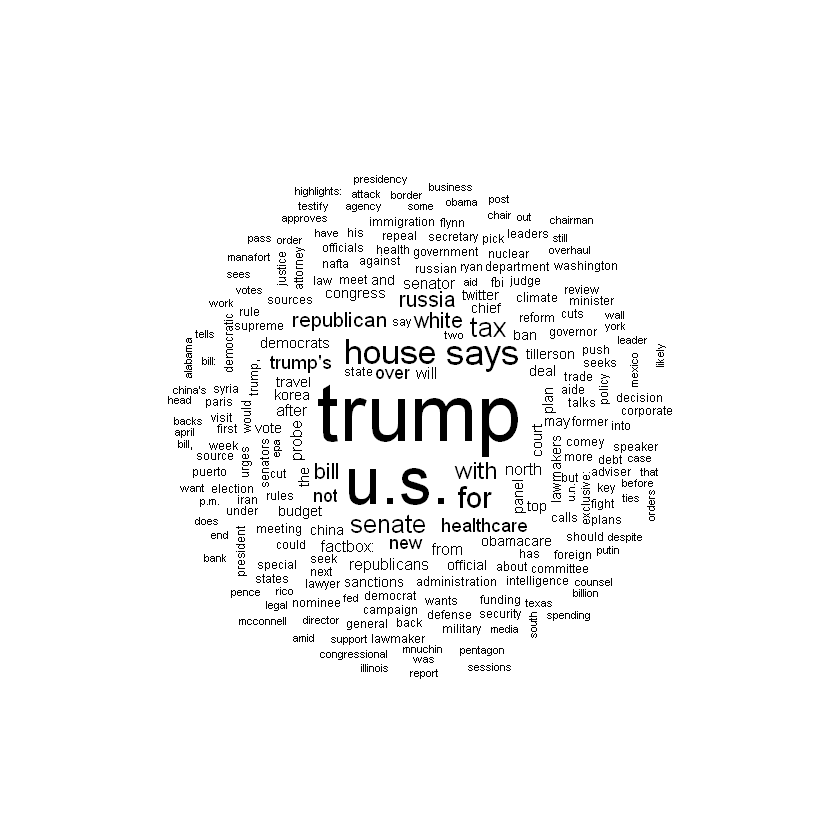

In [8]:
wordcloud(news_clean_corp_title[1:5000], min.freq = 30, random.order = FALSE)


Randomizing the data:

In [9]:
indx <- sample(1:nrow(news_title_dtm), as.integer(0.9*nrow(news_title_dtm)))


Here we create title Document-Term matrix training and test vectors and labels

In [10]:
news_title_dtm_train <- news_title_dtm[indx,]
news_title_dtm_test <- news_title_dtm[-indx,]
news_title_dtm_train_labels <- news_raw[indx,1]$status
news_title_dtm_test_labels <- news_raw[-indx,1]$status
prop.table(table(news_title_dtm_train_labels))

news_title_dtm_train_labels
     fake      real 
0.4453086 0.5546914 

In [11]:
prop.table(table(news_title_dtm_test_labels))

news_title_dtm_test_labels
     fake      real 
0.4366667 0.5633333 

Creating a character vector for frequent words

In [12]:
news_title_dtm_freq_train <- removeSparseTerms(news_title_dtm_train, 0.999)
news_title_dtm_train

<<DocumentTermMatrix (documents: 8100, terms: 13280)>>
Non-/sparse entries: 71036/107496964
Sparsity           : 100%
Maximal term length: 33
Weighting          : term frequency (tf)

A list of the most frequently used words in titles

In [13]:
news_title_freq_words<-findFreqTerms(news_title_dtm_train, 5)
str(news_title_freq_words)

 chr [1:2494] "'bathroom" "'dreamer'" "'dreamers'" "'great" "'no" "'no'" ...


Now we create the document-term matricies with only frequent terms, and convert these counts to factors.

In [14]:
news_title_dtm_freq_train <- news_title_dtm_train[ , news_title_freq_words]
news_title_dtm_freq_test <- news_title_dtm_test[ , news_title_freq_words]

convert_counts <- function(x) {
  x <- ifelse(x > 0, "Yes", "No")
}

class(news_title_dtm_freq_train)

[1] "DocumentTermMatrix"    "simple_triplet_matrix"

This applies the conversion function to the train/test data using apply()

In [15]:
news_title_train <- apply(news_title_dtm_freq_train, MARGIN = 2, convert_counts)
news_title_test <- apply(news_title_dtm_freq_test, MARGIN = 2, convert_counts)

#### Training a model on the data

Here we use the Naive Bayes algorithm to train the model and make predictions.

In [16]:
news_title_classifier <- naiveBayes(news_title_train, news_title_dtm_train_labels)

news_title_test_pred <- predict(news_title_classifier, news_title_test)
head(news_title_test_pred)

[1] real real real real real real
Levels: fake real

Evaluating model performance: 
The cross table will show us the rates of type 1 and type 2 errors.

In [17]:
CrossTable(news_title_test_pred, news_title_dtm_test_labels,
           prop.chisq = FALSE, prop.t = FALSE, prop.r = FALSE,
           dnn = c("Predected", "Actual"))


 
   Cell Contents
|-------------------------|
|                       N |
|           N / Col Total |
|-------------------------|

 
Total Observations in Table:  900 

 
             | Actual 
   Predected |      fake |      real | Row Total | 
-------------|-----------|-----------|-----------|
        fake |       360 |        23 |       383 | 
             |     0.916 |     0.045 |           | 
-------------|-----------|-----------|-----------|
        real |        33 |       484 |       517 | 
             |     0.084 |     0.955 |           | 
-------------|-----------|-----------|-----------|
Column Total |       393 |       507 |       900 | 
             |     0.437 |     0.563 |           | 
-------------|-----------|-----------|-----------|

 


The inital model can successfully predict fake news from the headline with a 91.46% accuracy, and real news at 95.3% accuracy using our test data. Perhaps we can do better

#### Improving model performance

In [18]:
news_title_classifier2 <- naiveBayes(news_title_train, news_title_dtm_train_labels, laplace = 1)

news_title_test_pred2 <- predict(news_title_classifier2, news_title_test)
head(news_title_test_pred2)

CrossTable(news_title_test_pred2, news_title_dtm_test_labels,
           prop.chisq = FALSE, prop.t = FALSE, prop.r = FALSE,
           dnn = c("Predected", "Actual"))

[1] real real real real real real
Levels: fake real


 
   Cell Contents
|-------------------------|
|                       N |
|           N / Col Total |
|-------------------------|

 
Total Observations in Table:  900 

 
             | Actual 
   Predected |      fake |      real | Row Total | 
-------------|-----------|-----------|-----------|
        fake |       374 |        23 |       397 | 
             |     0.952 |     0.045 |           | 
-------------|-----------|-----------|-----------|
        real |        19 |       484 |       503 | 
             |     0.048 |     0.955 |           | 
-------------|-----------|-----------|-----------|
Column Total |       393 |       507 |       900 | 
             |     0.437 |     0.563 |           | 
-------------|-----------|-----------|-----------|

 


We indeed were able to improve the model performance by applying the laplace smoother. Fake news detection accuracy was improved to 93.4%, however real news accuracy stayed about the same at 95.92%.